In [31]:
!date

Wed Jul 28 11:22:10 PDT 2021


# Class DE isoform hidden by gene

In [32]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [33]:
cluster_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='cluster_label',usecols=['cluster_label','cluster_color'])
cluster_cmap = cluster_cmap.drop_duplicates()
cluster_cmap = cluster_cmap.cluster_color.apply(lambda x: mcolors.to_rgb(x) )
cluster_cmap = cluster_cmap.to_dict()

In [34]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [35]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [36]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [37]:
isoform = isoform[isoform.obs.eval("cluster_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("cluster_label != 'L5 IT'").values]

In [38]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [39]:
gene.obs.cluster_label.value_counts()

363_DG                     1840
348_CA1-do                  486
191_L4/5 IT CTX             404
168_L2/3 IT CTX             385
133_L2 IT RSPv-POST-PRE     384
                           ... 
150_L2 IT ENTm                1
132_L2 IT RSPv-POST-PRE       1
129_L2/3 IT POST-PRE          1
124_L2 IT APr                 1
181_L4 IT CTX                 1
Name: cluster_label, Length: 346, dtype: int64

In [40]:
regions = gene.obs.region_label.unique()
clusters = gene.obs.cluster_label.unique()
breakdown = pd.DataFrame(index=clusters, columns=regions)
for region in regions:
    m = gene.obs.region_label == region
    r = gene.obs[m]
    d = r.cluster_label.value_counts()
    d = d.to_dict()
    breakdown[region] = breakdown.index.map(d)
breakdown

,HIP,ORB,ENTm,ENTl,SUB-ProS,AI,PL-ILA,TEa-PERI-ECT,RSP
345_CA1,18,0,0,0,2,0,0,0,0
362_DG,220,0,0,0,0,0,0,0,0
333_CA1-ProS,38,0,0,0,32,0,0,0,0
330_CA1-ProS,27,0,0,0,12,0,0,0,0
337_CA1,187,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
217_L6 IT CTX,0,0,0,0,0,0,0,0,1
245_L5 PT CTX,0,0,0,0,0,0,0,0,3
181_L4 IT CTX,0,0,0,0,0,0,0,0,1
258_L5 PT CTX,0,0,0,0,0,0,0,0,1


In [46]:
c = 3 #minimum number of columns that must satisfy criteria
n = 40 #minimum number of cells
b = breakdown.applymap(lambda x: x >=n)
for region in regions:
    b[region] = b[region].map({True:1,False:0})
m2 = b.sum(axis=1) >= c
f_breakdown =breakdown[m2]
f_breakdown

,HIP,ORB,ENTm,ENTl,SUB-ProS,AI,PL-ILA,TEa-PERI-ECT,RSP
290_L6 CT CTX,1,61,0,0,11,107,98,10,13
12_Lamp5,46,14,25,19,4,47,14,38,54
51_Vip,87,26,17,36,43,27,32,23,49
191_L4/5 IT CTX,0,122,0,0,0,102,167,12,1
168_L2/3 IT CTX,0,204,1,2,0,72,15,9,82
187_L4/5 IT CTX,0,62,0,0,0,75,53,7,0
167_L2/3 IT CTX,0,64,0,6,0,76,63,2,0
228_L6 IT CTX,0,52,1,0,0,57,12,1,56


In [47]:
def gene_dexpress(c_gene):
    mat           = c_gene.layers["log1p"].todense()
    components    = c_gene.obs.cell_id.values
    features      = c_gene.var.gene_name.values
    assignments   = c_gene.obs.region_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [48]:
def isoform_dexpress(c_isoform):
    mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
    components  = c_isoform.obs.cell_id.values
    features    = c_isoform.var.transcript_name.values
    assignments = c_isoform.obs.region_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
    markers_isoform = markers_isoform.query("es > 0")
    return markers_isoform

In [49]:
f_breakdown.index

CategoricalIndex(['290_L6 CT CTX', '12_Lamp5', '51_Vip', '191_L4/5 IT CTX',
                  '168_L2/3 IT CTX', '187_L4/5 IT CTX', '167_L2/3 IT CTX',
                  '228_L6 IT CTX'],
                 categories=['345_CA1', '362_DG', '333_CA1-ProS', '330_CA1-ProS', '337_CA1', '342_CA1', '344_CA1', '363_DG', ...], ordered=False, dtype='category')

In [50]:
f_breakdown.index[3]

'191_L4/5 IT CTX'

In [51]:
markers_gene = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','cluster'])
markers_isoform = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','cluster'])
for cluster in f_breakdown.index:
    mask = np.logical_and(gene.obs.cluster_label == cluster, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
    c_gene = gene[mask]
    c_isoform = isoform[mask]
    temp_gene = gene_dexpress(c_gene)
    temp_gene['cluster'] = cluster
    markers_gene = pd.concat([markers_gene,temp_gene])
    temp_isoform = isoform_dexpress(c_isoform)
    temp_isoform['cluster'] = cluster
    markers_isoform = pd.concat([markers_isoform,temp_isoform])
    

28-Jul-21 11:24:13 - 1 of 7 assignments: AI
28-Jul-21 11:24:13 - 2 of 7 assignments: HIP
28-Jul-21 11:24:13 - 3 of 7 assignments: ORB
28-Jul-21 11:24:14 - 4 of 7 assignments: PL-ILA
28-Jul-21 11:24:14 - 5 of 7 assignments: RSP
28-Jul-21 11:24:14 - 6 of 7 assignments: SUB-ProS
28-Jul-21 11:24:14 - 7 of 7 assignments: TEa-PERI-ECT
28-Jul-21 11:24:15 - 1 of 7 assignments: AI
28-Jul-21 11:24:15 - 2 of 7 assignments: HIP
28-Jul-21 11:24:15 - 3 of 7 assignments: ORB
28-Jul-21 11:24:16 - 4 of 7 assignments: PL-ILA
28-Jul-21 11:24:16 - 5 of 7 assignments: RSP
28-Jul-21 11:24:16 - 6 of 7 assignments: SUB-ProS
28-Jul-21 11:24:16 - 7 of 7 assignments: TEa-PERI-ECT
28-Jul-21 11:24:17 - 1 of 9 assignments: AI
28-Jul-21 11:24:17 - 2 of 9 assignments: ENTl
28-Jul-21 11:24:17 - 3 of 9 assignments: ENTm
28-Jul-21 11:24:17 - 4 of 9 assignments: HIP
28-Jul-21 11:24:17 - 5 of 9 assignments: ORB
28-Jul-21 11:24:17 - 6 of 9 assignments: PL-ILA
28-Jul-21 11:24:17 - 7 of 9 assignments: RSP
28-Jul-21 11:24:17 

In [65]:
%%time
clusters = np.sort(isoform.obs.cluster_label.unique())
n_cells = 50

de_RegionClusters = []
de_genes = []
de_isoforms = []

for cidx, c in enumerate(clusters):
    print(f"{cidx+1} of {len(clusters)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"cluster_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"cluster_label == '{c}'")].copy()
    
    big_enough_RegionClusters = tmp_gene.obs["region_label"].value_counts()[tmp_gene.obs["region_label"].value_counts()>n_cells].index.values
    if len(big_enough_RegionClusters) > 1:
        tmp_isoform = tmp_isoform[tmp_isoform.obs["region_label"].isin(big_enough_RegionClusters)].copy()
        tmp_gene = tmp_gene[tmp_gene.obs["region_label"].isin(big_enough_RegionClusters)].copy()
   
            
        de_RegionClusters.append(c)
        ####### Genes
        mat           = tmp_gene.layers["log1p"].todense()
        components    = tmp_gene.obs.cell_id.values
        features      = tmp_gene.var.gene_name.values
        assignments   = tmp_gene.obs.region_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in region
        corr_method   = "bonferroni"

        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

        # convert the 0 pvalues to the smallest possible float
        markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
        markers_gene["cluster"]=c
        markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
        de_genes.append(markers_gene)



        ######### Isoforms
        mat           = tmp_isoform.layers["log1p"].todense()
        components    = tmp_isoform.obs.cell_id.values
        features      = tmp_isoform.var.transcript_name.values
        assignments   = tmp_isoform.obs.region_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in region
        corr_method   = "bonferroni"


        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)
        #nick: bonferroni didn't work for some reason, doing it manually
        num_tests = len(markers_isoform['index'].unique())
        markers_isoform['p_corr'] = markers_isoform['p_raw'].apply(lambda x: x*num_tests)
        num_tests = len(markers_gene['index'].unique())
        markers_gene['p_corr'] = markers_gene['p_raw'].apply(lambda x: x*num_tests)
        #end nick
        # convert the 0 pvalues to the smallest possible float
        markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
        markers_isoform["cluster"]=c
        de_isoforms.append(markers_isoform)

1 of 346: 100_Sst
2 of 346: 101_Sst
3 of 346: 102_Sst Ctsc HPF
4 of 346: 103_Sst Ctsc HPF
5 of 346: 104_Sst Ctsc HPF
6 of 346: 105_Sst Ctsc HPF
7 of 346: 106_Sst Ctsc HPF
8 of 346: 107_Sst Ctsc HPF
9 of 346: 108_Pvalb
10 of 346: 109_Pvalb
11 of 346: 10_Lamp5
12 of 346: 110_Pvalb
13 of 346: 111_Pvalb
14 of 346: 112_Pvalb
15 of 346: 113_Pvalb
16 of 346: 114_Pvalb
17 of 346: 115_Pvalb
18 of 346: 116_Pvalb
19 of 346: 117_Pvalb
20 of 346: 118_Pvalb
21 of 346: 119_Pvalb
22 of 346: 11_Lamp5
23 of 346: 120_Pvalb
24 of 346: 121_Pvalb
25 of 346: 122_Pvalb Vipr2
26 of 346: 123_Pvalb Vipr2
27 of 346: 124_L2 IT APr
28 of 346: 129_L2/3 IT POST-PRE
29 of 346: 12_Lamp5
30 of 346: 131_L2/3 IT POST-PRE
31 of 346: 132_L2 IT RSPv-POST-PRE
32 of 346: 133_L2 IT RSPv-POST-PRE
33 of 346: 134_L2 IT RSP-ACA
34 of 346: 135_L3 IT ENTm
35 of 346: 136_L3 IT ENTm
36 of 346: 137_L3 IT ENTm
37 of 346: 138_L3 IT ENTm
38 of 346: 139_L3 IT ENTl
39 of 346: 13_Lamp5
40 of 346: 140_L3 IT ENTl
41 of 346: 142_L2/3 IT PAR
42 o

28-Jul-21 11:54:59 - 1 of 3 assignments: AI
28-Jul-21 11:54:59 - 2 of 3 assignments: ORB
28-Jul-21 11:54:59 - 3 of 3 assignments: PL-ILA
28-Jul-21 11:55:00 - 1 of 3 assignments: AI
28-Jul-21 11:55:00 - 2 of 3 assignments: ORB
28-Jul-21 11:55:00 - 3 of 3 assignments: PL-ILA


67 of 346: 168_L2/3 IT CTX


28-Jul-21 11:55:03 - 1 of 3 assignments: AI
28-Jul-21 11:55:03 - 2 of 3 assignments: ORB
28-Jul-21 11:55:03 - 3 of 3 assignments: RSP
28-Jul-21 11:55:04 - 1 of 3 assignments: AI
28-Jul-21 11:55:04 - 2 of 3 assignments: ORB
28-Jul-21 11:55:04 - 3 of 3 assignments: RSP


68 of 346: 169_L2/3 IT CTX
69 of 346: 16_Lamp5
70 of 346: 170_L2/3 IT CTX
71 of 346: 171_L2/3 IT CTX
72 of 346: 172_L2/3 IT ProS
73 of 346: 173_L2/3 IT ProS
74 of 346: 174_IT HATA
75 of 346: 175_IT HATA
76 of 346: 176_IT HATA
77 of 346: 177_IT HATA
78 of 346: 178_L4 IT CTX
79 of 346: 179_L4 IT CTX
80 of 346: 17_Lamp5
81 of 346: 180_L4 IT CTX
82 of 346: 181_L4 IT CTX
83 of 346: 182_L4/5 IT CTX
84 of 346: 183_L4/5 IT CTX
85 of 346: 184_L4/5 IT CTX
86 of 346: 185_L4/5 IT CTX
87 of 346: 186_L4/5 IT CTX
88 of 346: 187_L4/5 IT CTX


28-Jul-21 11:55:09 - 1 of 3 assignments: AI
28-Jul-21 11:55:09 - 2 of 3 assignments: ORB
28-Jul-21 11:55:09 - 3 of 3 assignments: PL-ILA
28-Jul-21 11:55:09 - 1 of 3 assignments: AI
28-Jul-21 11:55:10 - 2 of 3 assignments: ORB
28-Jul-21 11:55:10 - 3 of 3 assignments: PL-ILA


89 of 346: 188_L4/5 IT CTX
90 of 346: 189_L4/5 IT CTX
91 of 346: 18_Lamp5
92 of 346: 191_L4/5 IT CTX


28-Jul-21 11:55:13 - 1 of 3 assignments: AI
28-Jul-21 11:55:13 - 2 of 3 assignments: ORB
28-Jul-21 11:55:13 - 3 of 3 assignments: PL-ILA
28-Jul-21 11:55:14 - 1 of 3 assignments: AI
28-Jul-21 11:55:14 - 2 of 3 assignments: ORB
28-Jul-21 11:55:14 - 3 of 3 assignments: PL-ILA


93 of 346: 192_L4/5 IT CTX
94 of 346: 193_L4/5 IT CTX
95 of 346: 194_L5 IT RSP-ACA
96 of 346: 195_L5 IT RSP-ACA
97 of 346: 196_L5 IT CTX
98 of 346: 197_L5 IT CTX
99 of 346: 198_L5 IT CTX
100 of 346: 199_L5 IT CTX
101 of 346: 19_Pax6
102 of 346: 1_CR
103 of 346: 200_L5 IT CTX
104 of 346: 202_L5 IT CTX
105 of 346: 203_L5/6 IT CTX
106 of 346: 204_L5/6 IT CTX
107 of 346: 205_L5/6 IT CTX
108 of 346: 206_L5/6 IT CTX
109 of 346: 207_L5/6 IT CTX
110 of 346: 208_L5/6 IT CTX
111 of 346: 209_L5/6 IT CTX
112 of 346: 20_Pax6
113 of 346: 210_L5/6 IT TPE-ENT
114 of 346: 211_L5/6 IT TPE-ENT
115 of 346: 212_L5/6 IT TPE-ENT
116 of 346: 213_L5/6 IT TPE-ENT
117 of 346: 214_L5/6 IT PFC
118 of 346: 215_L5/6 IT TPE-ENT
119 of 346: 216_L5/6 IT TPE-ENT
120 of 346: 217_L6 IT CTX
121 of 346: 218_L6 IT CTX
122 of 346: 219_L6 IT CTX
123 of 346: 21_Sncg
124 of 346: 220_L6 IT CTX
125 of 346: 221_L6 IT CTX
126 of 346: 222_L6 IT CTX
127 of 346: 223_L6 IT CTX
128 of 346: 224_L6 IT CTX
129 of 346: 225_L6 IT CTX
130 of 3

28-Jul-21 11:55:22 - 1 of 3 assignments: AI
28-Jul-21 11:55:22 - 2 of 3 assignments: ORB
28-Jul-21 11:55:22 - 3 of 3 assignments: RSP
28-Jul-21 11:55:23 - 1 of 3 assignments: AI
28-Jul-21 11:55:23 - 2 of 3 assignments: ORB
28-Jul-21 11:55:23 - 3 of 3 assignments: RSP


133 of 346: 229_L6 IT CTX
134 of 346: 22_Sncg
135 of 346: 230_L6 IT CTX
136 of 346: 231_L6 IT CTX
137 of 346: 232_L6 IT CTX
138 of 346: 233_L6 IT ENTl
139 of 346: 234_L6 IT ENTl
140 of 346: 235_L6 IT ENTl
141 of 346: 236_Car3
142 of 346: 237_Car3
143 of 346: 238_Car3
144 of 346: 239_L5 PT CTX
145 of 346: 23_Sncg
146 of 346: 242_L5 PT CTX
147 of 346: 245_L5 PT CTX
148 of 346: 248_L5 PT CTX
149 of 346: 24_Sncg
150 of 346: 251_L5 PT CTX
151 of 346: 252_L5 PT CTX
152 of 346: 253_L5 PT CTX
153 of 346: 255_L5 PT CTX
154 of 346: 256_L5 PT CTX
155 of 346: 257_L5 PT CTX
156 of 346: 258_L5 PT CTX
157 of 346: 259_L5 PT CTX
158 of 346: 25_Sncg
159 of 346: 260_L5 PT CTX
160 of 346: 261_L4 RSP-ACA
161 of 346: 263_L5 PPP
162 of 346: 264_L5/6 NP CTX
163 of 346: 265_L5/6 NP CTX
164 of 346: 266_L5/6 NP CTX
165 of 346: 267_L5/6 NP CTX
166 of 346: 268_L5/6 NP CTX
167 of 346: 269_L5/6 NP CTX
168 of 346: 26_Ntng1 HPF
169 of 346: 270_L5/6 NP CT CTX
170 of 346: 271_NP SUB
171 of 346: 272_NP SUB
172 of 346: 27

28-Jul-21 11:55:36 - 1 of 3 assignments: AI
28-Jul-21 11:55:36 - 2 of 3 assignments: ORB
28-Jul-21 11:55:36 - 3 of 3 assignments: PL-ILA
28-Jul-21 11:55:37 - 1 of 3 assignments: AI
28-Jul-21 11:55:37 - 2 of 3 assignments: ORB
28-Jul-21 11:55:37 - 3 of 3 assignments: PL-ILA


190 of 346: 291_L6 CT CTX
191 of 346: 292_L6 CT CTX
192 of 346: 293_L6 CT CTX
193 of 346: 294_CT SUB
194 of 346: 295_CT SUB
195 of 346: 296_CT SUB
196 of 346: 297_CT SUB
197 of 346: 298_L6 CT ENT
198 of 346: 299_L6 CT ENT
199 of 346: 29_Ntng1 HPF
200 of 346: 2_Meis2
201 of 346: 300_L6b ENT


28-Jul-21 11:55:41 - 1 of 2 assignments: ENTl
28-Jul-21 11:55:41 - 2 of 2 assignments: ENTm
28-Jul-21 11:55:42 - 1 of 2 assignments: ENTl
28-Jul-21 11:55:42 - 2 of 2 assignments: ENTm


202 of 346: 301_L6b ENT
203 of 346: 302_L6b ENT
204 of 346: 303_L6b CTX
205 of 346: 304_L6b CTX
206 of 346: 305_L6b CTX
207 of 346: 306_L6b CTX
208 of 346: 30_Ntng1 HPF
209 of 346: 310_L6b RHP
210 of 346: 311_L6b CTX
211 of 346: 312_L6b CTX
212 of 346: 313_L6b CTX
213 of 346: 315_L6b CTX
214 of 346: 316_L6b CTX
215 of 346: 317_L6b CTX
216 of 346: 318_SUB
217 of 346: 319_SUB
218 of 346: 31_Sncg
219 of 346: 320_SUB
220 of 346: 321_SUB
221 of 346: 322_ProS
222 of 346: 323_ProS
223 of 346: 324_ProS
224 of 346: 326_ProS
225 of 346: 327_ProS
226 of 346: 328_ProS
227 of 346: 329_CA1-ProS
228 of 346: 32_Sncg
229 of 346: 330_CA1-ProS
230 of 346: 331_CA1-ProS
231 of 346: 332_CA1-ProS
232 of 346: 333_CA1-ProS
233 of 346: 334_CA1-ve
234 of 346: 335_CA1-ve
235 of 346: 336_CA1-ve
236 of 346: 337_CA1
237 of 346: 338_CA1
238 of 346: 339_CA1
239 of 346: 33_Sncg
240 of 346: 340_CA1
241 of 346: 341_CA1
242 of 346: 342_CA1
243 of 346: 343_CA1
244 of 346: 344_CA1
245 of 346: 345_CA1
246 of 346: 346_CA1-do


In [69]:
markers_gene = pd.concat(de_genes)

markers_isoform = pd.concat(de_isoforms)

markers_isoform.sort_values('es')

,index,name,p_raw,p_corr,es,cluster
52537,AI,Dnajc21-201_ENSMUST00000136591.8,1.29903e-13,3.897104e-13,-1.35996,187_L4/5 IT CTX
63836,AI,mt-Nd4l-201_ENSMUST00000084013.1,0.000999192,2.997576e-03,-1.12755,187_L4/5 IT CTX
112896,ENTm,Rasal1-205_ENSMUST00000156722.2,9.93771e-06,1.987541e-05,-1.12744,300_L6b ENT
96721,ORB,Enpp2-201_ENSMUST00000041591.16,8.89257e-07,2.667770e-06,-1.11605,187_L4/5 IT CTX
2464,AI,Rab3b-201_ENSMUST00000003502.4,5.11463e-07,1.534390e-06,-1.10752,290_L6 CT CTX
...,...,...,...,...,...,...
145503,ORB,Rps13-ps1-201_ENSMUST00000183478.2,1.17545e-27,3.526344e-27,2.35818,290_L6 CT CTX
145503,ORB,Rps13-ps1-201_ENSMUST00000183478.2,8.11868e-42,2.435603e-41,2.50928,191_L4/5 IT CTX
71397,AI,Pcp4-201_ENSMUST00000061739.9,2.82922e-17,8.487664e-17,2.55611,168_L2/3 IT CTX
64351,AI,Nnat-205_ENSMUST00000153739.9,5.1382e-13,1.541460e-12,2.56178,228_L6 IT CTX


In [72]:
markers_gene.sort_values('es')

,index,name,p_raw,p_corr,es,cluster,n_isoforms,index_name
10612,AI,Dnajc21_ENSMUSG00000044224.17,4.15465e-13,1.246394e-12,-1.30978,187_L4/5 IT CTX,4,AI_Dnajc21
56759,RSP,Tmeff2_ENSMUSG00000026109.15,2.91965e-10,8.758958e-10,-1.21885,168_L2/3 IT CTX,2,RSP_Tmeff2
7163,AI,Cryab_ENSMUSG00000032060.11,3.71291e-05,1.113874e-04,-1.14081,228_L6 IT CTX,6,AI_Cryab
13871,AI,mt-Nd4l_ENSMUSG00000065947.1,0.000999192,2.997576e-03,-1.12755,187_L4/5 IT CTX,1,AI_mt-Nd4l
68842,PL-ILA,Smim43_ENSMUSG00000085007.4,2.29832e-13,6.894952e-13,-1.12053,191_L4/5 IT CTX,3,PL-ILA_Smim43
...,...,...,...,...,...,...,...,...
14052,AI,Nnat_ENSMUSG00000067786.17,3.09541e-13,9.286218e-13,2.45342,228_L6 IT CTX,9,AI_Nnat
40068,ORB,Rps13-ps1_ENSMUSG00000066362.6,8.11867e-42,2.435602e-41,2.50928,191_L4/5 IT CTX,1,ORB_Rps13-ps1
17861,AI,Pcp4_ENSMUSG00000090223.3,1.54868e-18,4.646041e-18,2.54199,168_L2/3 IT CTX,4,AI_Pcp4
55807,RSP,Satb1_ENSMUSG00000023927.16,2.88509e-32,8.655274e-32,2.67218,168_L2/3 IT CTX,12,RSP_Satb1


In [67]:
#mask = np.logical_and(gene.obs.cluster_label == 'Vip', np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#mask = (gene.obs.cluster_label == 'Vip')

#c_gene = gene[mask]
#c_isoform = isoform[mask]
#markers_gene= gene_dexpress(c_gene)
#markers_isoform = isoform_dexpress(c_isoform)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [70]:
alpha =0.01#/len(f_breakdown.index) #second bonferroni correction for multiple clusters being tested
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [71]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,cluster,index_name
216553,PL-ILA,Mrps12-203_ENSMUST00000165246.2,3.03037e-08,9.091111e-08,1.43327,167_L2/3 IT CTX,PL-ILA_Mrps12
29891,ENTl,Prkcz-201_ENSMUST00000030922.15,8.15991e-08,1.631982e-07,1.18347,300_L6b ENT,ENTl_Prkcz
166712,PL-ILA,Crbn-202_ENSMUST00000113239.10,0.000205446,6.163371e-04,1.18134,187_L4/5 IT CTX,PL-ILA_Crbn
244284,PL-ILA,7SK.188-201_ENSMUST00020183253.1,2.69928e-07,8.097854e-07,1.13046,290_L6 CT CTX,PL-ILA_7SK.188
172701,PL-ILA,Tbk1-201_ENSMUST00000020316.4,0.000249223,7.476688e-04,1.07024,167_L2/3 IT CTX,PL-ILA_Tbk1
162757,ORB,7SK.188-201_ENSMUST00020183253.1,4.31959e-07,1.295876e-06,1.04986,187_L4/5 IT CTX,ORB_7SK.188
147383,ORB,Rpl37rt-202_ENSMUST00000124641.2,0.000525115,1.575344e-03,1.02885,228_L6 IT CTX,ORB_Rpl37rt
91419,ORB,Llph-202_ENSMUST00000130198.3,4.4946e-06,1.348380e-05,1.02,290_L6 CT CTX,ORB_Llph
26156,ENTl,Atp9a-201_ENSMUST00000029060.11,0.000176892,3.537833e-04,0.994788,300_L6b ENT,ENTl_Atp9a
24591,AI,Upp2-206_ENSMUST00000137007.2,2.49236e-05,7.477089e-05,0.983991,228_L6 IT CTX,AI_Upp2


In [81]:
markers_gene[markers_gene.name.str.contains("Mrps12")]
#markers_gene[markers_gene.name.str.contains("Kifap")]

,index,name,p_raw,p_corr,es,cluster,n_isoforms,index_name
10926,AI,Mrps12_ENSMUSG00000045948.9,0.876659,2.629977,-0.00623613,167_L2/3 IT CTX,4,AI_Mrps12
37080,ORB,Mrps12_ENSMUSG00000045948.9,0.93327,2.799810,-0.00400701,167_L2/3 IT CTX,4,ORB_Mrps12
63234,PL-ILA,Mrps12_ENSMUSG00000045948.9,0.805112,2.415336,0.0108659,167_L2/3 IT CTX,4,PL-ILA_Mrps12
10926,AI,Mrps12_ENSMUSG00000045948.9,0.265251,0.795754,0.0389132,168_L2/3 IT CTX,4,AI_Mrps12
37080,ORB,Mrps12_ENSMUSG00000045948.9,0.321685,0.965054,-0.0329817,168_L2/3 IT CTX,4,ORB_Mrps12
63234,RSP,Mrps12_ENSMUSG00000045948.9,0.810652,2.431957,0.0103771,168_L2/3 IT CTX,4,RSP_Mrps12
10926,AI,Mrps12_ENSMUSG00000045948.9,0.227352,0.682056,-0.0568263,187_L4/5 IT CTX,4,AI_Mrps12
37080,ORB,Mrps12_ENSMUSG00000045948.9,0.0172982,0.051895,0.113909,187_L4/5 IT CTX,4,ORB_Mrps12
63234,PL-ILA,Mrps12_ENSMUSG00000045948.9,0.243054,0.729162,-0.0569972,187_L4/5 IT CTX,4,PL-ILA_Mrps12
10926,AI,Mrps12_ENSMUSG00000045948.9,0.950192,2.850576,0.00194946,191_L4/5 IT CTX,4,AI_Mrps12


In [74]:
#specific_region = "Glutamatergic"
#specific_gene = "Kifap3_ENSMUSG00000026585.14"
#specific_isoform = "Kifap3-202_ENSMUST00000077642.12"

#specific_region = "ENTl"
specific_region = "PL-ILA"
specific_gene = "Mrps12_ENSMUSG00000045948.9"
specific_isoform = "Mrps12-203_ENSMUST00000165246.2"
specific_cluster = '167_L2/3 IT CTX'

In [77]:
isoform_f = isoform[isoform.obs.eval(f"cluster_label == '{specific_cluster}'")]
gene_f = gene[gene.obs.eval(f"cluster_label == '{specific_cluster}'")]
#need to filter out subclasses that are too small
big_enough_RegionClusters = gene_f.obs["region_label"].value_counts()[gene_f.obs["region_label"].value_counts()>n_cells].index.values
isoform_f = isoform_f[isoform_f.obs["region_label"].isin(big_enough_RegionClusters)].copy()
gene_f = gene_f[gene_f.obs["region_label"].isin(big_enough_RegionClusters)].copy()

In [78]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


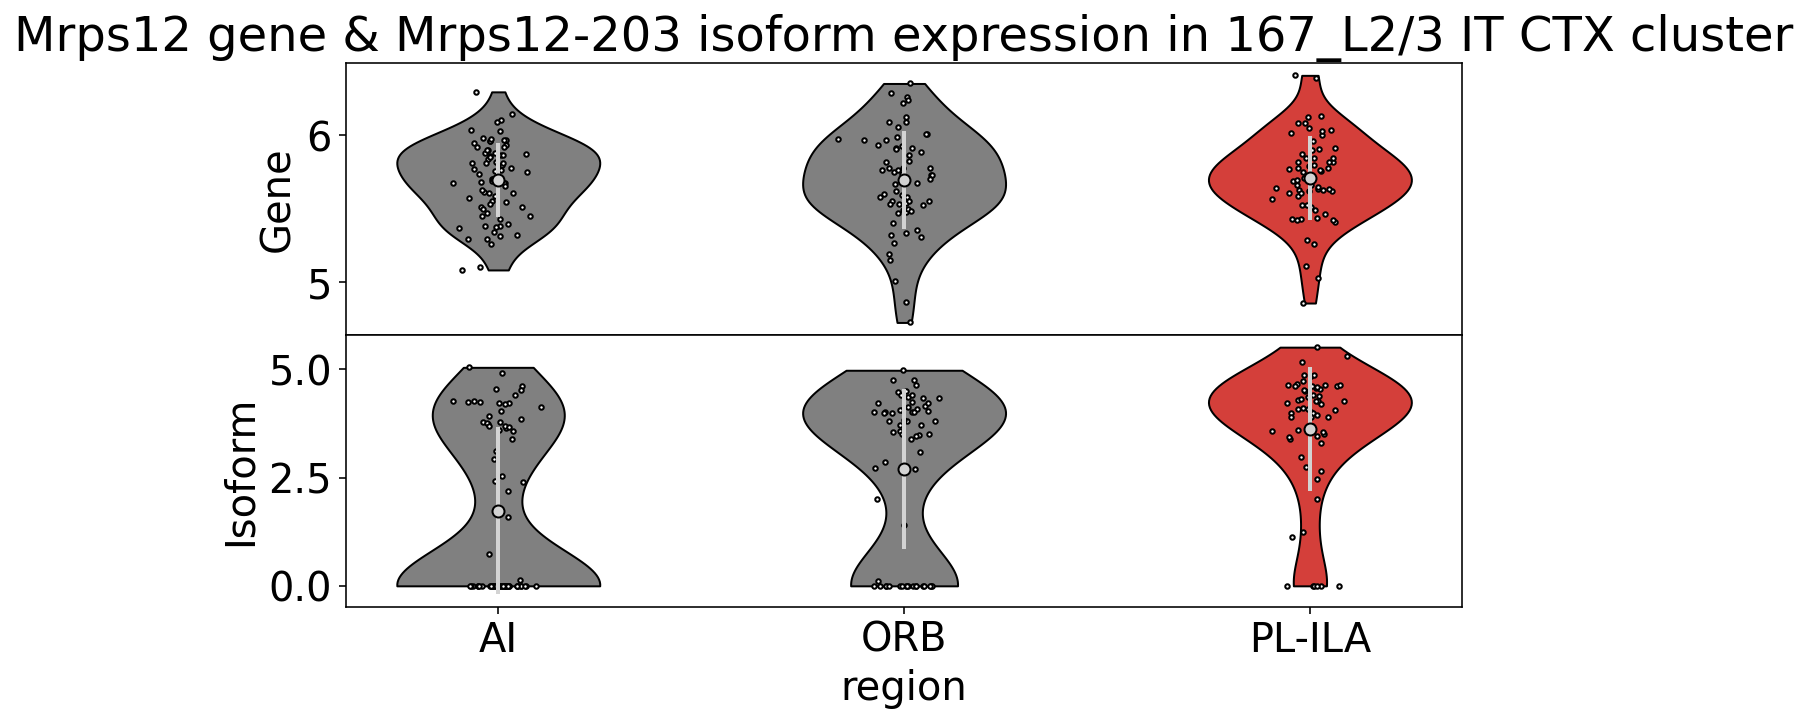

In [83]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

#mask = np.logical_and(gene.obs.cluster_label == specific_cluster, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#c_gene = gene[mask]
#c_isoform = isoform[mask]
c_gene = gene_f
c_isoform = isoform_f
# Declare
unique = np.unique(c_gene.obs.region_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_region)[0][0]
#plt.xticks(rotation=270)
plt.xlabel("region")

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(c_gene[c_gene.obs.region_label==c][:,c_gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(c_isoform[c_isoform.obs.region_label==c][:,c_isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression in {} cluster".format(specific_gene.split("_")[0], specific_isoform.split("_")[0],specific_cluster),
    "ylabel":"Gene",
})

#need to figure out what ax[0] and ax[1] are
ymin, ymax = ax[1].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/region_cluster_DE_violin_all.png", bbox_inches='tight',dpi=300)
plt.show()

# gene.obs

In [24]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 18175 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

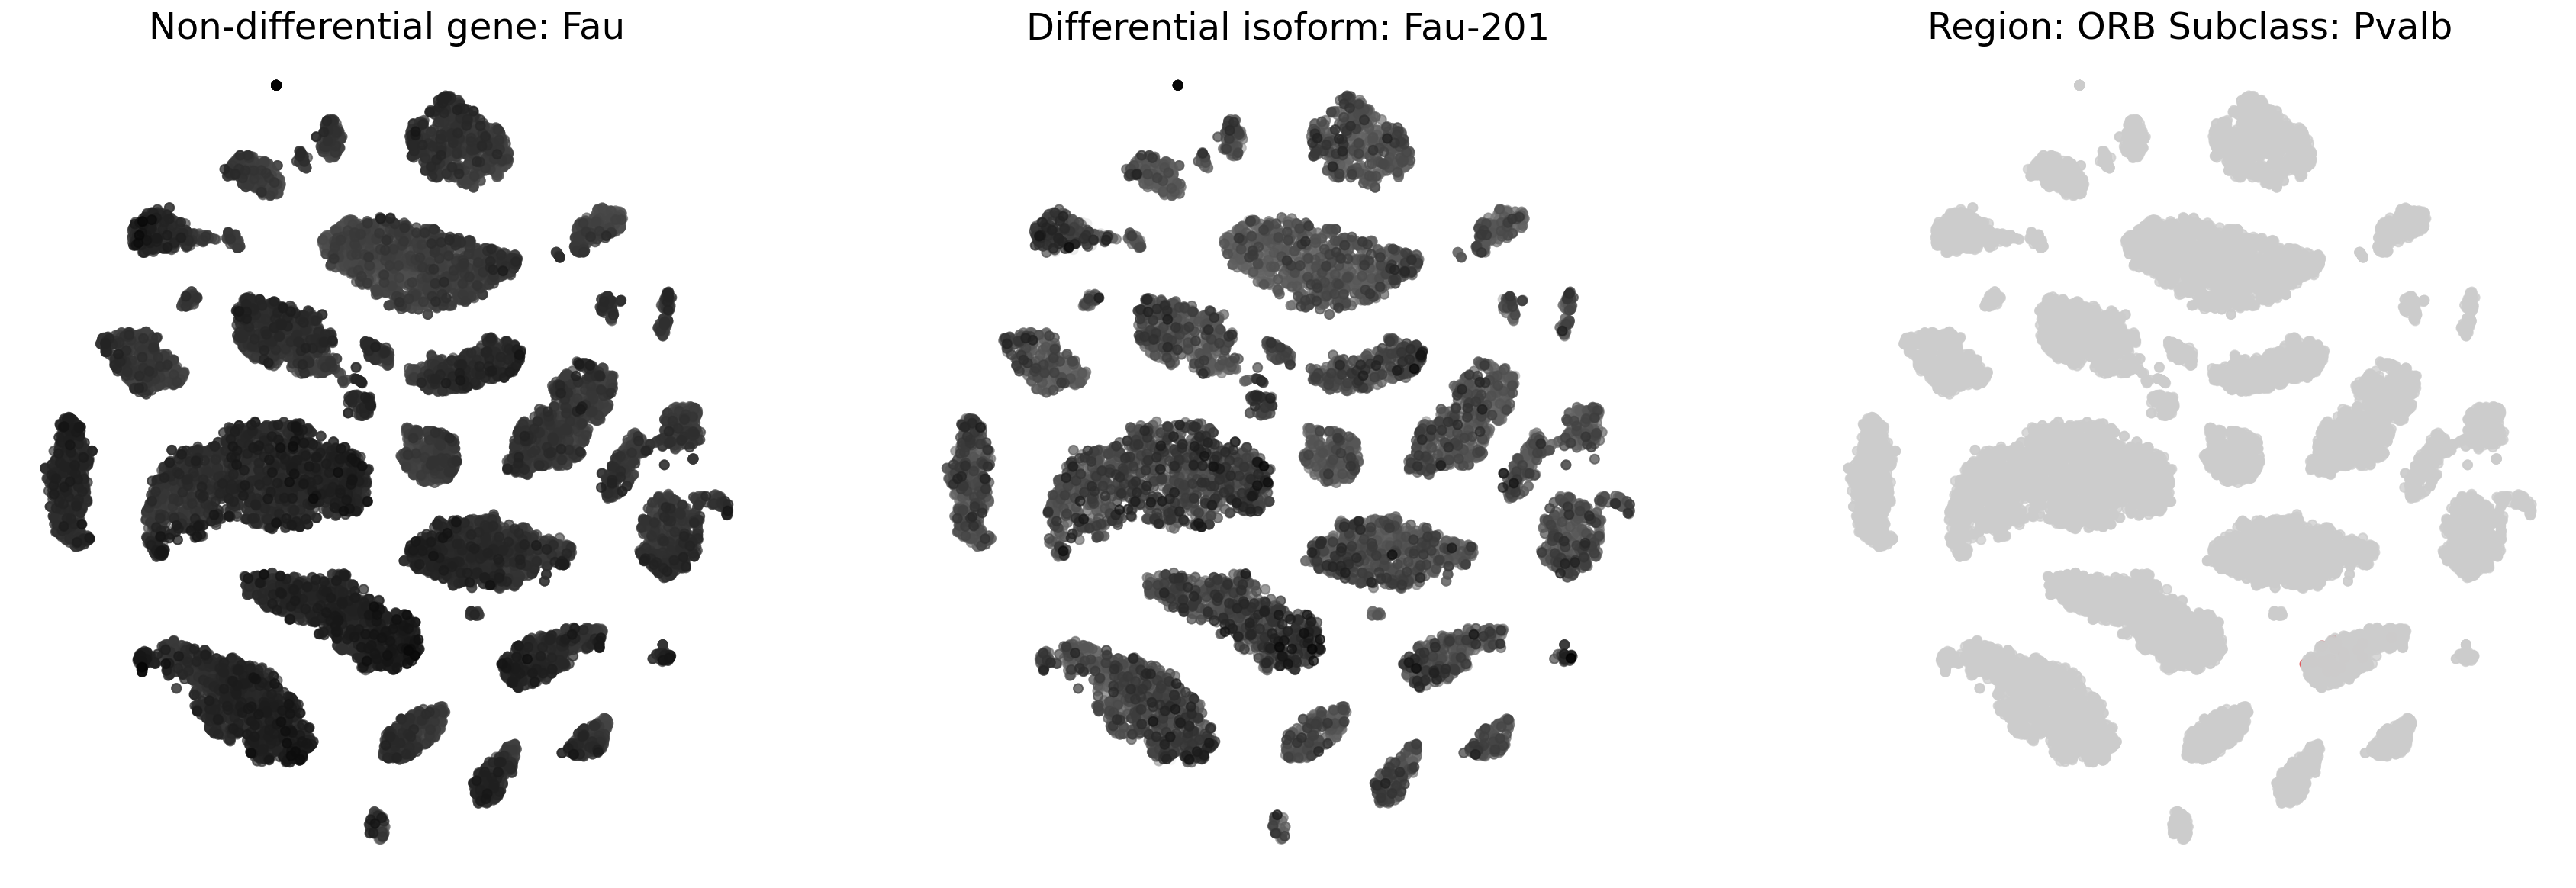

In [25]:
#this figure doesnt really make sense to be used
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["cluster_label"]==specific_region
c = gene.obs["cluster_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(np.logical_or(gene.obs["region_label"]!=specific_region, gene.obs["cluster_label"]!=specific_cluster))[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Region: {} cluster: {}".format(specific_region,specific_cluster))
plt.savefig("../../figures/region_cluster_DE_nca_all.png", bbox_inches='tight',dpi=300)
plt.show()

In [26]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [27]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [28]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

614 isoforms from 418 genes identified.


In [29]:
markers_isoform.to_csv("../../tables/unordered/region_cluster_DE.csv")